# NLP Analysis of Tweets from SXSW 2011

Import necessary libraries.

In [109]:
import pandas as pd
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras import regularizers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, plot_confusion_matrix
from nltk.corpus import stopwords as sw
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import  word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.set_option ('display.max_colwidth', None)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import source.src as nlp_functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [110]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

There are 5802 missing values telling what the tweet is directed at. A way to combat this would be to look at the tweet and look for keywords such as iphone or ipad and assign who it is directed to that way.

In [111]:
#Drop the 1 NA value from our 'tweet_text' column in our dataset
df = df.dropna(subset=['tweet_text'])

In [112]:
#Remove puncuation and other unnecessary characters
df['tweet_text'] = df['tweet_text'].str.replace(r'[^\w\s]', '')
df['tweet_text'] = df['tweet_text'].str.replace('quot', '')
# Make lower case and split
df['tweet_text'] = df['tweet_text'].str.lower()

In [113]:
snbstem = SnowballStemmer('english')
df['stem_text'] = df['tweet_text'].apply(lambda x: [snbstem.stem(x)])

In [114]:
df['tweet_text'] = df['tweet_text'].str.split(' ')

Here we do some basic cleaning of the data set, removing punctuation, making everything lower case, and splitting the data. We also use snowball stemmer.

In [115]:
#Make a blank column to set up for some data cleaning
df['test'] = ''
# Fill in the values with a string na to avoid errors
df.fillna('na',inplace=True)

In [116]:
#This salvages a lot of our data

#Lists to check for key words in the body of tweets
apple = ['iphone','ipad','apple','apples','ipads']
android = ['android','google','androids','googles']

# Loop through the tweet column and look for keywords to assign product to
for ind , val in enumerate(df['tweet_text']):
    if df['emotion_in_tweet_is_directed_at'].values[ind] == 'na':
        for y in val:
            if y in apple:
                df['test'].values[ind] = y
            elif y in android:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['emotion_in_tweet_is_directed_at'].values[ind]

For this process, we looped over the tweets themselves to see if we could determine what product or company the tweet was regarding.

In [117]:
len(df.loc[df['test'] == ''])

915

We managed to fill in 4886 rows of missing data with our for loop.

In [118]:
#Make everything lower case to make values match
df['test'] = df['test'].map(lambda x : x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service', '',
       'googles', 'ipads', 'apples', 'other apple product or service',
       'androids'], dtype=object)

In [119]:
#This cell replaces words with the rightful product to reduce unique values
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads':'ipad'})


In [120]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Looking at the target of our dataset, there are four different values. Negative emotion, positive emotion, no emotion, and I can't tell. Let's get a closer look at these 'I can't tell' labels.

In [121]:
len(df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"])

156

Since this makes up such a small amount of our data, we will move the `I can't tell` value to that of neutral, along with the value `No emotion toward brand or product`.

In [122]:
#Here we change targets into more readable text
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(emotion_dict)

In [123]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion', 'Neutral emotion'],
      dtype=object)

We have now turned our dataset into a ternary classification set.

In [124]:
#Turn our targets into number values
target_dict = {'Negative emotion': 2, 'Neutral emotion': 1, 'Positive emotion': 0}
df_test = df.copy()
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(target_dict)

# EDA

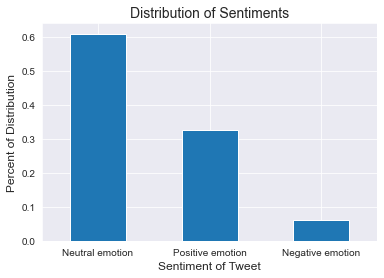

In [125]:
#This cell plots the distributions of our sentiments
df_dist = df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count()
fig ,ax = plt.subplots()
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True).plot.bar()

plt.xticks(rotation=0,fontsize=10)
ax.set_xlabel('Sentiment of Tweet',fontsize=12)
ax.set_ylabel('Percent of Distribution',fontsize=12)
ax.set_title('Distribution of Sentiments',fontsize=14);

This makes the breakdown of our target values 60% neutral, 34% positive, and 6% negative.

In [126]:
df['product'] = df['test'].map(nlp_functions.company_search)

Now we rename our columns to make it readable.

In [127]:
df = df.rename(columns={'tweet_text': 'Text','emotion_in_tweet_is_directed_at': 'Product',
                        'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion','test':'Recovered Products',
                        'product':'company','stem_text': 'clean_tweet'})

Here we make data frames of the separate companies to do some exploration of the tweets about them.

In [128]:
df_apple = df.loc[df['company'] == 'apple']
df_google = df.loc[df['company'] == 'google']

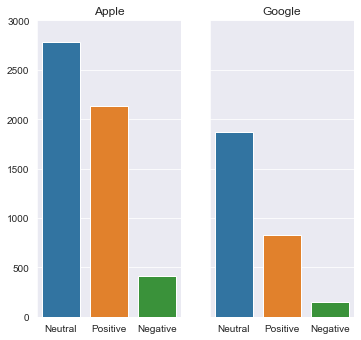

In [129]:
plt.figure(figsize=(15, 12))

sns.set_style('darkgrid')


ax1 = plt.subplot2grid(shape=(2,5), loc = (0,0))
ax2 = plt.subplot2grid(shape=(2,5), loc = (0,1),)

sns.barplot(x = df_apple['Emotion'].value_counts().index,
           y = df_apple['Emotion'].value_counts().values,
           ax =ax1)
ax1.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax1.set_title('Apple')
ax1.set_ylim(0,3000)

sns.barplot(x = df_google['Emotion'].value_counts().index,
           y = df_google['Emotion'].value_counts().values,
           ax = ax2)
ax2.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax2.set_title('Google')
ax2.set_ylim(0,3000)
ax2.set(yticklabels = []);

Chart showing distribution of tweet sentiment by category of item tweeted about. It seems that Apple has more tweets overall, along with more positive tweets.

In [130]:
#Make a dictionary for the recovered products
cat_dict = {'iphone' : 'Phone/iPad', 'android': 'Phone/iPad', 'ipad': 'Phone/iPad', 'apple':'Platform',
'google':'Platform', 'ipad or iphone app': 'App', 'android app': 'App', 'other google product or service' : 'Other product/service',
'other apple product or service': 'Other product/service', 'ios': 'Other product/service', 'itunes': 'Other product/service'}
df['category'] = df['Recovered Products'].map(cat_dict)

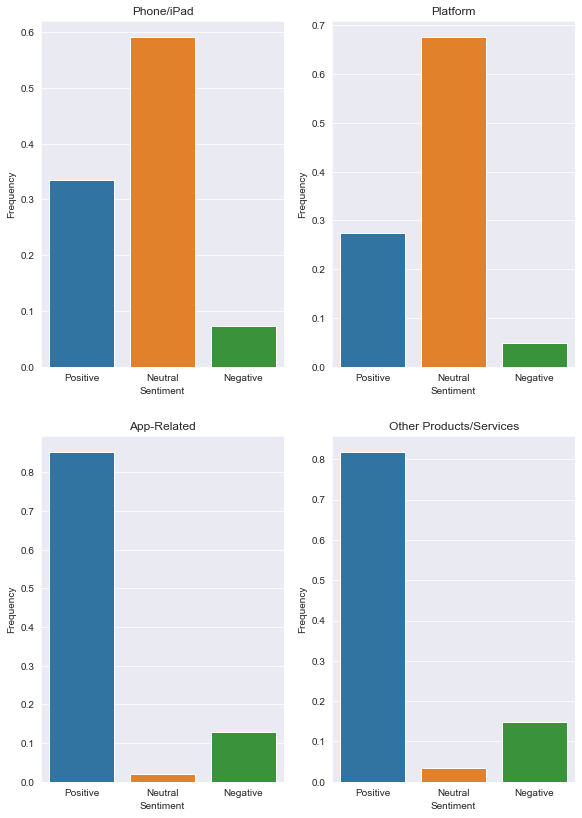

In [131]:
#This cell focuses on creating visuals for tweets about some products themselves
plt.figure(figsize=(20,14))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))

sns.barplot(x = df.loc[df.category == 'Phone/iPad']['target'].value_counts().index,
               y = df.loc[df.category == 'Phone/iPad']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('Phone/iPad')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Positive', 'Neutral', 'Negative'])

sns.barplot(x = df.loc[df.category == 'Platform']['target'].value_counts().index,
            y = df.loc[df.category == 'Platform']['target'].value_counts(normalize=True),
           ax=ax2)
ax2.set_title('Platform')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Positive', 'Neutral', 'Negative'])

sns.barplot(x = df.loc[df.category == 'App']['target'].value_counts().index,
               y = df.loc[df.category == 'App']['target'].value_counts(normalize=True),
           ax=ax3)
ax3.set_title('App-Related')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Positive', 'Neutral', 'Negative'])

sns.barplot(x = df.loc[df.category == 'Other product/service']['target'].value_counts().index,
               y = df.loc[df.category == 'Other product/service']['target'].value_counts(normalize=True),
           ax=ax4)
ax4.set_title('Other Products/Services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Positive', 'Neutral', 'Negative']);

Apps and other products seem to have the highest percentage of positive tweets, perhaps because apps were new and very popular at the time. (This data IS from 2011.)

In [132]:
#Create a series of clean tweets in order to explore further
pos_tweets = df['clean_tweet']
pos_tweets

0                          [wesley83 i have a 3g iphone after 3 hrs tweeting at rise_austin it was dead  i need to upgrade plugin stations at sxsw]
1              [jessedee know about fludapp  awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at sxsw]
2                                                                      [swonderlin can not wait for ipad 2 also they should sale them down at sxsw]
3                                                                    [sxsw i hope this years festival isnt as crashy as this years iphone app sxsw]
4                           [sxtxstate great stuff on fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress]
                                                                           ...                                                                     
9088                                                                                                            

In [133]:
#Create empty lists for appending
raw_pos = []
raw_neg = []
raw_neu = []

#Split up the tweets into positive, negative, and neutral
pos_tweets = df.loc[df.target==0]
pos_tweets

neg_tweets = df.loc[df.target==2]

neutral_tweets = df.loc[df.target==1]

#Loop through the tweets and put them into our lists
for listx in pos_tweets.clean_tweet:
    for x in listx:
        raw_pos.append(x)
    
for listx in neg_tweets.clean_tweet:
    for x in listx:
        raw_neg.append(x)
        
for listx in neutral_tweets.clean_tweet:
    for x in listx:
        raw_neu.append(x)

#Join them to make it one long string
raw_pos = ' '.join(raw_pos)
raw_neg = ' '.join(raw_neg)
raw_neu = ' '.join(raw_neu)

In [134]:
#Here we are making the top words into a data frame and applying TFIDFVectorizer to them
word_list = [raw_pos, raw_neg, raw_neu]
df_raw = pd.DataFrame(word_list, index = ['positive', 'negative', 'neutral'], columns = ['raw_text'])
#Apply the vectorizer and transform data
tfidf_raw = TfidfVectorizer(stop_words = sw.words(), max_features=500)
X_raw = tfidf_raw.fit_transform(df_raw.raw_text)
df_topwords = pd.DataFrame(X_raw.toarray(), columns = tfidf_raw.get_feature_names(), index=df_raw.index)

In [135]:
#Limit the words in our dictionaries
top_poswords = dict(df_topwords.loc[['positive']].max().sort_values(ascending=False)[:150])
top_negwords = dict(df_topwords.loc[['negative']].max().sort_values(ascending=False)[:100])

In [136]:
#Create empty lists for positive keys and values to get ready for a wordcloud
pos_keys = []
pos_vals = []

#loop through the positive dictionary to create a new dictionary
for word, item in top_poswords.items():
    if word not in top_negwords.keys():
        pos_keys.append(word)
        pos_vals.append(item)
        
#Zip the lists together to create our dictionary for the wordcloud        
pos_dict1 = dict(zip(pos_keys, pos_vals))
del pos_dict1['ûïmention']

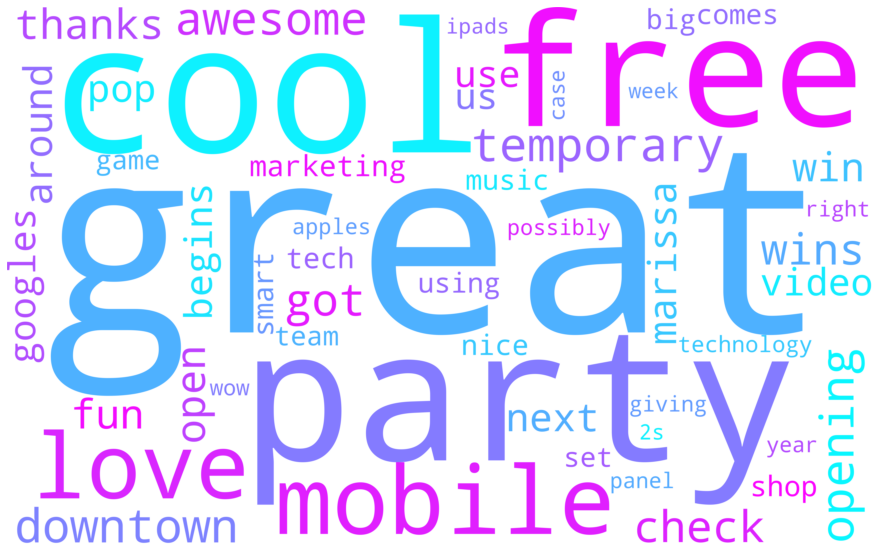

In [137]:
#This cell creates the wordcloud from the top words unique to the positive classification
wc = WordCloud(background_color="white",width=8000,height=5000, max_words=50,relative_scaling=0.5,normalize_plurals=False, colormap = 'cool').generate_from_frequencies(pos_dict1)
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

In [138]:
#The same process for the positive words is repeated for the negative words
neg_keys = []
neg_vals = []

for word, item in top_negwords.items():
    if word not in top_poswords.keys():
        neg_keys.append(word)
        neg_vals.append(item)

        
neg_dict1 = dict(zip(neg_keys, neg_vals))
del neg_dict1['ive']

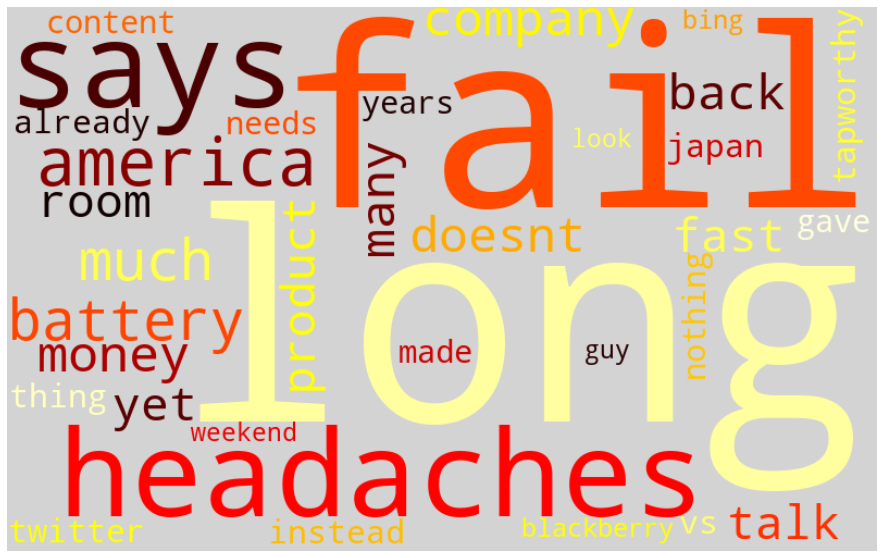

In [139]:
#The wordcloud is then made for the negative words
wc = WordCloud(background_color="lightgray",width=800,height=500, max_words=50,relative_scaling=0.5,normalize_plurals=False, colormap = 'hot').generate_from_frequencies(neg_dict1)
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

# Testing

In [140]:
#Map out our values to prepare for modeling
target_dict = {'Negative emotion': 2, 'Neutral emotion': 1, 'Positive emotion': 0}
df_test = df.copy()

In [141]:
X = df_test['clean_tweet'].str.join(' ')
y = df_test['target']

In [142]:
# Make Our test and train set
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=50)

In [143]:
def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds,average='micro')}
Precision Score: {precision_score(y_true,y_preds,average='micro')}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds,average='micro')}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

## CountVectorizer with Naive Bayes

In [144]:
#For our first model we will try a CountVectorizer with Naive Bayes
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_train)
X_t_vec = cv.fit_transform(X_train)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)

In [145]:
mnb = MultinomialNB()

In [146]:
mnb.fit(X_t_vec,y_train)
results = cross_validate(mnb,X_t_vec,y_train,return_train_score=True)

In [147]:
nlp_functions.mean_scores(results)

Mean Train Score: 0.8321601089694137
Mean Test Score: 0.6580142776306361


Our first look at the model, it seems to be overfit. It has high variance from our test and train scores.

In [148]:
y_hat = cross_val_predict(mnb,X_t_vec,y_train)
metrics(y_train,y_hat)

Recall Score: 0.6580143716087403
Precision Score: 0.6580143716087403
Accuracy Score:0.6580143716087403
F1 Score: 0.6580143716087403
Confusion Matrix: 
[[1199 1030   17]
 [ 852 3250   55]
 [ 147  231   38]]


This model doesn't do a great job predicting negative sentiments. Let's look at other models to see what we can find.

## CountVectorizer Logistic Regression

In [149]:
lr_pipe = Pipeline([("vec" , CountVectorizer(stop_words=sw.words('english'))),
                       ("lr",LogisticRegression(C=.5,solver='saga'))])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
nlp_functions.mean_scores(results_LR)

Mean Train Score: 0.8999852633248304
Mean Test Score: 0.6844115425908435


This scores better than our first model.

In [150]:
y_hat_lr = cross_val_predict(lr_pipe, X_train, y_train)
metrics(y_train,y_hat_lr)

Recall Score: 0.6847045021264115
Precision Score: 0.6847045021264115
Accuracy Score:0.6847045021264115
F1 Score: 0.6847045021264115
Confusion Matrix: 
[[1099 1130   17]
 [ 606 3507   44]
 [  87  266   63]]


This model seems to do a better job at predicting the negative sentiment, but lost some positive sentiments. This is a better model than our first one.

## TFIDFVectorizer with Naive Bayes

In [151]:
pipe_tf = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), MultinomialNB())
cv = cross_validate(pipe_tf, X_train, y_train,return_train_score=True)

In [153]:
nlp_functions.mean_scores(cv)

Mean Train Score: 0.7552426545099736
Mean Test Score: 0.6512682262475177


This is our worst model yet.

In [154]:
y_hat_tf = cross_val_predict(pipe_tf, X_train, y_train)
metrics(y_train,y_hat_tf)

Recall Score: 0.6512685144449333
Precision Score: 0.6512685144449333
Accuracy Score:0.6512685144449333
F1 Score: 0.6512685144449333
Confusion Matrix: 
[[ 433 1813    0]
 [ 154 4002    1]
 [  29  381    6]]


This model cannot predict any negatives at all. 

## TFIDVectorizer Random Forest

In [155]:
pipe_rf = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), RandomForestClassifier())
cv = cross_validate(pipe_rf, X_train, y_train,return_train_score=True)
nlp_functions.mean_scores(cv)

Mean Train Score: 0.9961871456948479
Mean Test Score: 0.6732646202636499


In [156]:
y_hat_rf = cross_val_predict(pipe_rf, X_train, y_train)
metrics(y_train,y_hat_rf)

Recall Score: 0.6704795424549054
Precision Score: 0.6704795424549054
Accuracy Score:0.6704795424549054
F1 Score: 0.6704795424549054
Confusion Matrix: 
[[ 811 1434    1]
 [ 409 3713   35]
 [  52  316   48]]


Nothing too special about this model. It is not the highest scoring and does a decent job of classifying negatives.

## TfidVectorizer Logistic Regression

In [157]:
lr_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words='english')),
                       ("lr",LogisticRegression())])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
nlp_functions.mean_scores(results_LR)

Mean Train Score: 0.8257810370641157
Mean Test Score: 0.684705873493652


In [158]:
y_hat_lr = cross_val_predict(lr_pipe,X_train,y_train)
metrics(y_train,y_hat_lr)

Recall Score: 0.6847045021264115
Precision Score: 0.6847045021264115
Accuracy Score:0.6847045021264115
F1 Score: 0.6847045021264115
Confusion Matrix: 
[[ 977 1267    2]
 [ 480 3673    4]
 [  80  317   19]]


Although this does give a good accuracy score, the negative classifying isn't quite there. This model does the best overall on accuracy though. Let's tune some hyperparameters.

In [159]:
lr_grid = {'lr__C' : [.5, 1, 50],
       'lr__max_iter' : [50,100,1750, 2000],
       }

clf_lr = GridSearchCV(lr_pipe,lr_grid,return_train_score=True)

In [160]:
lr_results = clf_lr.fit(X_train,y_train)
nlp_functions.gs_mean_scores(lr_results)

Mean Train Score: 0.8517317508487197'
Mean Test Score: 0.6751608994591742


In [161]:
clf_lr.best_params_


{'lr__C': 1, 'lr__max_iter': 100}

In [162]:
lr_pipe2 = Pipeline([("tfid" , TfidfVectorizer(stop_words='english')),
                       ("lr",LogisticRegression(max_iter=50))])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
nlp_functions.mean_scores(results_LR)

Mean Train Score: 0.8257810370641157
Mean Test Score: 0.684705873493652


In [163]:
y_preds = cross_val_predict(lr_pipe2,X_train,y_train)
metrics(y_train,y_preds)

Recall Score: 0.6832380114386274
Precision Score: 0.6832380114386274
Accuracy Score:0.6832380114386274
F1 Score: 0.6832380114386274
Confusion Matrix: 
[[ 974 1269    3]
 [ 486 3667    4]
 [  79  319   18]]


This model performs well but is still struggling with the negative classification.

## Keras Neural Network

In [164]:
y_nn = df['target']
x_nn = df['clean_tweet']

In [165]:
model_nn = Sequential()
model_nn.add(Embedding(7000, 100))
model_nn.add(LSTM(25))
model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dense(3, activation='relu'))

In [166]:
text_t = text.Tokenizer(num_words=7000)
text_t.fit_on_texts((x_nn))
list_tt = text_t.texts_to_sequences(x_nn)
x_nn = sequence.pad_sequences(list_tt)

In [167]:
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         700000    
_________________________________________________________________
lstm (LSTM)                  (None, 25)                12600     
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 714,053
Trainable params: 714,053
Non-trainable params: 0
_________________________________________________________________


In [168]:
results = model_nn.fit(x_nn, y_nn, epochs=10)

Epoch 1/10
285/285 [==============================] - 1s 4ms/step - loss: 1.0483 - accuracy: 0.1998
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: -0.3021 - accuracy: 0.4022
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6135 - accuracy: 0.6303
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: -0.5124 - accuracy: 0.6445
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6087 - accuracy: 0.6996
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6200 - accuracy: 0.7335
Epoch 7/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6141 - accuracy: 0.7281
Epoch 8/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6123 - accuracy: 0.6838
Epoch 9/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6156 - accuracy: 0.7522
Epoch 10/10
285/285 [==============================] - 1s 4ms/step - loss: -0.6147 - accurac

In [169]:
score = model_nn.evaluate(x_nn, y_nn, verbose=0)
score

[-0.615888237953186, 0.5588429570198059]

This model has an accuracy of about 56%, making it our worst model yet.

## TFIDVectorizer SVC Classifier

In [170]:
svc_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words=sw.words('english'))),
                     ("svc", SVC())])
results_svc = cross_validate(svc_pipe,X_train,y_train,return_train_score=True)
nlp_functions.mean_scores(results_svc)

Mean Train Score: 0.9144302625318858
Mean Test Score: 0.6823590793983428


In [171]:
y_svc = cross_val_predict(svc_pipe,X_train,y_train)
metrics(y_train,y_svc)

Recall Score: 0.6823581170259568
Precision Score: 0.6823581170259568
Accuracy Score:0.6823581170259568
F1 Score: 0.6823581170259568
Confusion Matrix: 
[[ 836 1409    1]
 [ 362 3786    9]
 [  55  330   31]]


This model gives us high accuracy but still struggles with negative tweets. Let's try some hyperparameter tuning.

In [172]:
svc_params = {'svc__C': [1,2,3,4,5],
             'svc__kernel':['linear','rbf','sigmoid','poly'],
              'svc__degree':[3,5,7,8],
             }

svc_gs = GridSearchCV(estimator=svc_pipe, param_grid=svc_params, return_train_score=True)

In [173]:
gs_results = svc_gs.fit(X_train,y_train)

In [174]:
svc_gs.best_params_

{'svc__C': 2, 'svc__degree': 3, 'svc__kernel': 'rbf'}

GridSearch has determined these are our best parameters, so let's rerun the model with these to see what we get.

In [175]:
svc_pipe2 = Pipeline([("tfid" , TfidfVectorizer(stop_words=sw.words('english'))),
                     ("svc", SVC(C=2,kernel='rbf',degree=3))])
results_svc = cross_validate(svc_pipe2,X_train,y_train,return_train_score=True)
nlp_functions.mean_scores(results_svc)

Mean Train Score: 0.9591581884305341
Mean Test Score: 0.6860236927770594


In [176]:
y_svc2 = cross_val_predict(svc_pipe2,X_train,y_train)
metrics(y_train,y_svc2)

Recall Score: 0.6860243437454172
Precision Score: 0.6860243437454172
Accuracy Score:0.6860243437454172
F1 Score: 0.6860243437454172
Confusion Matrix: 
[[1083 1157    6]
 [ 574 3543   40]
 [  76  288   52]]


This model gives the highest accuracy and does the best job at classifying negative sentiments. We will choose this as our final model.

# Final Model - TFIDVectorizer with SVC Classifier

In [177]:
svc_pipe2.fit(X_train,y_train)
svc_pipe2.score(X_test,y_test)

0.7021557413110426

This gives us a 70% accuracy on our test set.

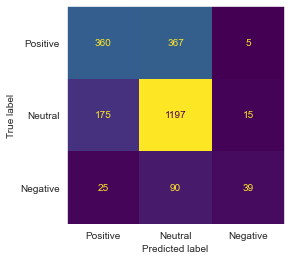

In [178]:
plot_confusion_matrix(svc_pipe2,X_test,y_test,display_labels=['Positive','Neutral','Negative'],colorbar=False)
plt.grid(False);

Our model needs improvement on finding negative sentiments. Moving forward we would like to find more negative tweets for further model training. More data would help improve the accuracy.